# Global Health Outcomes: The Relationship Between Healthcare Capacity and COVID-19 Impact Across Countries

## Executive Summary

This report analyses the relationship between healthcare infrastructure, health spending, and COVID-19 outcomes across countries worldwide. For this, three key findings emerge: (1) Countries with higher pre-pandemic healthcare capacity (hospital beds per capital) experienced lower COVID-19 mortality rates, (2) Health expenditure as a percentage of GDP shows a moderate positive correlation with better health outcomes during the pandemic, and (3) Significant regional disparities exist in both healthcare infrastructure and pandemic outcomes, with developed countries generally faring better. The purpose of this project was to understand how pre-existing healthcare systems influenced countries' ability to respond to the COVID-19 pandemic. Important results indicate that healthcare infrastructure investment is associated with better pandemic resilience, and recommendations include prioritising healthcare capacity building in developing regions and establishing global health equity initiatives.

## Introduction

The COVID-19 pandemic exposed profound differences in countries’ abilities to manage fast-moving global health crisis. While the virus affected all nations, the severity of its impact varied sharply: some countries were able to maintain relatively low infection and mortality rates, while others faced overwhelming case surges, high fatality levels, and prolonged health system strain. These contrasting outcomes suggest that national responses were shaped by more than the virus itself, raising critical questions about which underlying factors most strongly influenced a country’s ability to control the pandemic. In particular, the strength of pre-existing healthcare infrastructure and the overall capacity of national health systems appear to be central determinants worth examining in depth.

Understanding how healthcare capacity relates to pandemic outcomes is important for several reasons. First, it can clarify which components of a health system, such as hospital bed availability, workforce density, diagnostic capacity, or public health investment, most directly contribute to reducing mortality during large-scale outbreaks. Second, it brings attention to global health inequities that left some countries far more vulnerable than others, revealing structural gaps that require long-term international support and policy reform. Third, such insights are essential for policymakers who must prioritise limited resources and design effective preparedness strategies for future emergencies.

A data-driven approach is particularly well suited to this research question because the scale and complexity of the pandemic cannot be captured through qualitative observation alone. Analysing large, multi-country datasets allows for systematic comparison of healthcare indicators, such as ICU capacity, physician-to-population ratios, health expenditure levels, and testing rates, alongside COVID-19 metrics like case fatality rates, excess mortality, or hospitalisation trends. This integration makes it possible to identify statistically meaningful patterns and evaluate how differences in health system capacity shaped real-world outcomes. Moreover, the availability of robust, openly accessible datasets from sources such as Our World in Data, the World Bank, and the World Health Organisation ensures that the analysis can be grounded in reliable, standardised global evidence.

## Methods

### Data Sources

For the analysis two primary datasets were utilised to examine the relationship between healthcare capacity and COVID-19 outcomes:

**Dataset 1: Our World in Data COVID-19 Dataset**
- Source: GitHub repository (https://github.com/owid/covid-19-data)
- Description: Comprehensive global COVID-19 data including cases, deaths, hospitalisations, testing, and vaccination metrics by country and date
- Coverage: 200+ countries from January 2020 to present
- License: Creative Commons Attribution 4.0 International

**Dataset 2: World Bank Health Indicators**
- Source: World Bank Open Data API (https://data.worldbank.org/)
- Description: Global health system indicators including life expectancy, health expenditure (% of GDP), hospital beds per 1,000 people, and under-5 mortality rates
- Coverage: 265 countries from 2010-2023
- License: World Bank Terms of Use (Open Data)


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set up paths
data_dir = Path('data')
raw_data_dir = data_dir / 'raw'
cleaned_data_dir = data_dir / 'cleaned'
cleaned_data_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Raw data directory: {raw_data_dir}")
print(f"Cleaned data directory: {cleaned_data_dir}")

Libraries imported successfully
Raw data directory: data/raw
Cleaned data directory: data/cleaned


In [3]:
# Load the raw datasets
print("Loading datasets...")

# Load COVID-19 data
covid_df = pd.read_csv(raw_data_dir / 'owid_covid_data.csv')
print(f"\nCOVID-19 dataset loaded:")
print(f"  Shape: {covid_df.shape}")
print(f"  Date range: {covid_df['date'].min()} to {covid_df['date'].max()}")
print(f"  Countries: {covid_df['location'].nunique()}")

# Load World Bank health indicators
wb_df = pd.read_csv(raw_data_dir / 'world_bank_health_indicators.csv')
print(f"\nWorld Bank health indicators loaded:")
print(f"  Shape: {wb_df.shape}")
print(f"  Countries: {wb_df['country'].nunique()}")
print(f"  Indicators: {wb_df['indicator'].unique()}")

# Display first few rows of each dataset
print("\n" + "="*60)
print("COVID-19 Dataset - First 5 rows:")
print("="*60)
print(covid_df[['location', 'date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']].head())

print("\n" + "="*60)
print("World Bank Dataset - First 5 rows:")
print("="*60)
print(wb_df.head())


Loading datasets...

COVID-19 dataset loaded:
  Shape: (429435, 67)
  Date range: 2020-01-01 to 2024-08-14
  Countries: 255

World Bank health indicators loaded:
  Shape: (12245, 6)
  Countries: 265
  Indicators: ['life_expectancy' 'health_expenditure' 'hospital_beds' 'mortality_rate']

COVID-19 Dataset - First 5 rows:
      location        date  total_cases  total_deaths  new_cases  new_deaths
0  Afghanistan  2020-01-05          0.0           0.0        0.0         0.0
1  Afghanistan  2020-01-06          0.0           0.0        0.0         0.0
2  Afghanistan  2020-01-07          0.0           0.0        0.0         0.0
3  Afghanistan  2020-01-08          0.0           0.0        0.0         0.0
4  Afghanistan  2020-01-09          0.0           0.0        0.0         0.0

World Bank Dataset - First 5 rows:
                       country country_code        indicator  indicator_code  \
0  Africa Eastern and Southern          AFE  life_expectancy  SP.DYN.LE00.IN   
1  Africa Eastern and


### Data Cleaning

The data cleaning process involved several key steps to prepare the datasets for analysis:

**COVID-19 Dataset Cleaning:**
1. Converted the date column to datetime format for proper temporal analysis
2. Filtered out aggregate regions (e.g., "World", "Europe", "High income") to focus on individual countries, removing 11,755 rows of aggregate data
3. Extracted a snapshot of cumulative COVID-19 metrics as of December 31, 2022, providing a comprehensive view of total pandemic impact
4. Selected key variables including total cases, total deaths, deaths per million, vaccination rates, and ICU/hospitalisation metrics
5. Calculated mortality rate (deaths per case percentage) while handling division by zero errors
6. Standardised country codes using ISO 3166-1 alpha-3 codes

**World Bank Dataset Cleaning:**
1. Pivoted the dataset from long format (one row per country-indicator-year) to wide format (one column per indicator)
2. Extracted the most recent available year of data for each country-indicator combination to ensure we use the most current pre-pandemic healthcare capacity metrics
3. Renamed columns for clarity (e.g., `health_expenditure` to `health_expenditure_pct_gdp`, `hospital_beds` to `hospital_beds_per_1000`)
4. Handled missing values, with 25 countries missing health expenditure data, 49 missing hospital bed data, and 21 missing mortality rate data


#### Initial Data Exploration

Examining the structure and quality of both datasets to identify cleaning requirements.


In [4]:
# Explore COVID-19 dataset structure
print("COVID-19 Dataset Information:")
print("="*60)
print(f"Total rows: {len(covid_df):,}")
print(f"Total columns: {len(covid_df.columns)}")
print(f"\nColumn names:")
print(covid_df.columns.tolist())

print("\n" + "="*60)
print("Data Types:")
print("="*60)
print(covid_df.dtypes.value_counts())

print("\n" + "="*60)
print("Missing Values (top 20 columns):")
print("="*60)
missing_covid = covid_df.isnull().sum().sort_values(ascending=False)
print(missing_covid[missing_covid > 0].head(20))

print("\n" + "="*60)
print("Sample of key columns:")
print("="*60)
key_cols = ['location', 'date', 'total_cases', 'total_deaths', 'icu_patients', 'hosp_patients', 
            'total_vaccinations', 'people_fully_vaccinated']
available_cols = [col for col in key_cols if col in covid_df.columns]
print(covid_df[available_cols].head(10))


COVID-19 Dataset Information:
Total rows: 429,435
Total columns: 67

Column names:
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundre

In [5]:
# Explore World Bank dataset structure
print("World Bank Health Indicators Dataset Information:")
print("="*60)
print(f"Total rows: {len(wb_df):,}")
print(f"Total columns: {len(wb_df.columns)}")
print(f"\nColumn names: {wb_df.columns.tolist()}")

print("\n" + "="*60)
print("Data Types:")
print("="*60)
print(wb_df.dtypes)

print("\n" + "="*60)
print("Missing Values:")
print("="*60)
missing_wb = wb_df.isnull().sum()
print(missing_wb[missing_wb > 0])

print("\n" + "="*60)
print("Unique values per column:")
print("="*60)
print(f"Countries: {wb_df['country'].nunique()}")
print(f"Country codes: {wb_df['country_code'].nunique()}")
print(f"Indicators: {wb_df['indicator'].unique()}")
print(f"Years: {sorted(wb_df['year'].unique())}")

print("\n" + "="*60)
print("Sample data by indicator:")
print("="*60)
for indicator in wb_df['indicator'].unique():
    print(f"\n{indicator}:")
    sample = wb_df[wb_df['indicator'] == indicator].head(3)
    print(sample[['country', 'year', 'value']])


World Bank Health Indicators Dataset Information:
Total rows: 12,245
Total columns: 6

Column names: ['country', 'country_code', 'indicator', 'indicator_code', 'year', 'value']

Data Types:
country            object
country_code       object
indicator          object
indicator_code     object
year                int64
value             float64
dtype: object

Missing Values:
country_code    197
dtype: int64

Unique values per column:
Countries: 265
Country codes: 261
Indicators: ['life_expectancy' 'health_expenditure' 'hospital_beds' 'mortality_rate']
Years: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

Sample data by indicator:

life_expectancy:
                       country  year      value
0  Africa Eastern and Southern  2023  65.146291
1  Africa Eastern and Southern  2022  64.487020
2  Africa Eastern and 

#### Data Cleaning

Based on the initial exploration, several cleaning steps were performed as follows:

1. **COVID-19 Dataset Cleaning:**
   - Convert date column to datetime format
   - Handle missing values appropriately
   - Filter to country-level data (exclude aggregates like "World", "Europe")
   - Extract key metrics for analysis
   - Standardise country codes

2. **World Bank Dataset Cleaning:**
   - Pivot from long to wide format (one column per indicator)
   - Handle missing values
   - Standardise country codes to match COVID-19 data
   - Filter to most recent available year for each indicator

3. **Data Integration:**
   - Merge datasets on country codes
   - Align time periods
   - Handle mismatched country names/codes


In [6]:
# Step 1: Clean COVID-19 dataset
print("Cleaning COVID-19 dataset...")
print("="*60)

# Convert date to datetime
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Identify aggregate regions to exclude (these are not individual countries)
exclude_locations = ['World', 'International', 'Europe', 'Asia', 'Africa', 'North America', 
                     'South America', 'Oceania', 'European Union', 'High income', 
                     'Upper middle income', 'Lower middle income', 'Low income']
covid_clean = covid_df[~covid_df['location'].isin(exclude_locations)].copy()

print(f"Rows after excluding aggregates: {len(covid_clean):,} (removed {len(covid_df) - len(covid_clean):,})")

# Extract key metrics - we'll use cumulative totals as of a specific date (end of 2022)
# This gives us a snapshot of total impact
analysis_date = '2022-12-31'
covid_snapshot = covid_clean[covid_clean['date'] == analysis_date].copy()

print(f"\nCountries with data on {analysis_date}: {len(covid_snapshot)}")

# Select key columns for analysis
covid_cols = ['location', 'iso_code', 'population', 'total_cases', 'total_deaths', 
              'total_cases_per_million', 'total_deaths_per_million', 
              'total_vaccinations_per_hundred', 'people_fully_vaccinated_per_hundred',
              'icu_patients_per_million', 'hosp_patients_per_million']

available_covid_cols = [col for col in covid_cols if col in covid_snapshot.columns]
covid_analysis = covid_snapshot[available_covid_cols].copy()

# Calculate mortality rate (deaths per case)
if 'total_cases' in covid_analysis.columns and 'total_deaths' in covid_analysis.columns:
    covid_analysis['mortality_rate'] = (covid_analysis['total_deaths'] / 
                                       covid_analysis['total_cases'] * 100)
    covid_analysis['mortality_rate'] = covid_analysis['mortality_rate'].replace([np.inf, -np.inf], np.nan)

print(f"\nFinal COVID-19 dataset shape: {covid_analysis.shape}")
print(f"Missing values:")
print(covid_analysis.isnull().sum()[covid_analysis.isnull().sum() > 0])


Cleaning COVID-19 dataset...
Rows after excluding aggregates: 417,680 (removed 11,755)

Countries with data on 2022-12-31: 252

Final COVID-19 dataset shape: (252, 12)
Missing values:
total_cases                             13
total_deaths                            13
total_cases_per_million                 13
total_deaths_per_million                13
total_vaccinations_per_hundred         216
people_fully_vaccinated_per_hundred    218
icu_patients_per_million               228
hosp_patients_per_million              227
mortality_rate                          15
dtype: int64


In [7]:
# Step 2: Clean World Bank dataset
print("Cleaning World Bank dataset...")
print("="*60)

# Pivot from long to wide format
wb_pivot = wb_df.pivot_table(
    index=['country', 'country_code', 'year'],
    columns='indicator',
    values='value',
    aggfunc='first'
).reset_index()

print(f"Shape after pivoting: {wb_pivot.shape}")
print(f"Columns: {wb_pivot.columns.tolist()}")

# Get the most recent year of data for each country and indicator
# First, let's get the latest available year for each country-indicator combination
wb_latest = wb_df.copy()
wb_latest = wb_latest.sort_values(['country_code', 'indicator', 'year'], ascending=[True, True, False])
wb_latest = wb_latest.drop_duplicates(subset=['country_code', 'indicator'], keep='first')

# Now pivot this latest data
wb_analysis = wb_latest.pivot_table(
    index=['country', 'country_code'],
    columns='indicator',
    values='value',
    aggfunc='first'
).reset_index()

# Rename columns to be more readable
wb_analysis.columns.name = None
wb_analysis = wb_analysis.rename(columns={
    'health_expenditure': 'health_expenditure_pct_gdp',
    'hospital_beds': 'hospital_beds_per_1000',
    'life_expectancy': 'life_expectancy_years',
    'mortality_rate': 'under5_mortality_per_1000'
})

print(f"\nFinal World Bank dataset shape: {wb_analysis.shape}")
print(f"Columns: {wb_analysis.columns.tolist()}")
print(f"\nMissing values:")
print(wb_analysis.isnull().sum()[wb_analysis.isnull().sum() > 0])


Cleaning World Bank dataset...
Shape after pivoting: (3654, 7)
Columns: ['country', 'country_code', 'year', 'health_expenditure', 'hospital_beds', 'life_expectancy', 'mortality_rate']

Final World Bank dataset shape: (261, 6)
Columns: ['country', 'country_code', 'health_expenditure_pct_gdp', 'hospital_beds_per_1000', 'life_expectancy_years', 'under5_mortality_per_1000']

Missing values:
health_expenditure_pct_gdp    25
hospital_beds_per_1000        49
under5_mortality_per_1000     21
dtype: int64



**Data Integration:**
1. Merged the COVID-19 and World Bank datasets on ISO country codes using an inner join
2. This resulted in a final merged dataset of 216 countries with both COVID-19 outcomes and healthcare indicators
3. Filtered the dataset to include only countries with at least COVID-19 death data and at least one healthcare indicator, resulting in 213 countries for analysis
4. Identified and documented countries present in one dataset but not the other (31 countries in COVID data only, 46 in World Bank data only)


In [8]:
# Step 3: Merge datasets
print("Merging datasets...")
print("="*60)

# Merge on ISO country codes
# COVID-19 uses 'iso_code', World Bank uses 'country_code'
# Both should be ISO 3166-1 alpha-3 codes

merged_df = covid_analysis.merge(
    wb_analysis,
    left_on='iso_code',
    right_on='country_code',
    how='inner',
    suffixes=('_covid', '_wb')
)

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Countries in merged dataset: {len(merged_df)}")

# Check for countries that didn't merge
covid_only = set(covid_analysis['iso_code'].dropna()) - set(wb_analysis['country_code'].dropna())
wb_only = set(wb_analysis['country_code'].dropna()) - set(covid_analysis['iso_code'].dropna())

if len(covid_only) > 0:
    print(f"\nCountries in COVID data but not in World Bank: {len(covid_only)}")
    print(f"Examples: {list(covid_only)[:5]}")
if len(wb_only) > 0:
    print(f"\nCountries in World Bank but not in COVID data: {len(wb_only)}")
    print(f"Examples: {list(wb_only)[:5]}")

# Display merged dataset info
print("\n" + "="*60)
print("Merged Dataset - Column Summary:")
print("="*60)
print(f"Total columns: {len(merged_df.columns)}")
print(f"\nKey columns available:")
key_merged_cols = ['location', 'iso_code', 'total_deaths_per_million', 'mortality_rate',
                   'health_expenditure_pct_gdp', 'hospital_beds_per_1000', 
                   'life_expectancy_years', 'population']
available_merged_cols = [col for col in key_merged_cols if col in merged_df.columns]
print(available_merged_cols)


Merging datasets...
Merged dataset shape: (216, 18)
Countries in merged dataset: 216

Countries in COVID data but not in World Bank: 31
Examples: ['OWID_KOS', 'MSR', 'OWID_EUN', 'OWID_HIC', 'GGY']

Countries in World Bank but not in COVID data: 46
Examples: ['EMU', 'ARB', 'LDC', 'AFW', 'MNA']

Merged Dataset - Column Summary:
Total columns: 18

Key columns available:
['location', 'iso_code', 'total_deaths_per_million', 'mortality_rate', 'health_expenditure_pct_gdp', 'hospital_beds_per_1000', 'life_expectancy_years', 'population']


In [9]:
# Step 4: Handle missing values and outliers
print("Handling missing values and outliers...")
print("="*60)

# Create a working dataset with key variables
analysis_cols = ['location', 'iso_code', 'population', 
                 'total_deaths_per_million', 'mortality_rate',
                 'health_expenditure_pct_gdp', 'hospital_beds_per_1000',
                 'life_expectancy_years']

# Select only columns that exist
final_cols = [col for col in analysis_cols if col in merged_df.columns]
final_df = merged_df[final_cols].copy()

print(f"Working dataset shape: {final_df.shape}")

# Check missing values
print("\nMissing values before cleaning:")
missing_before = final_df.isnull().sum()
print(missing_before[missing_before > 0])

# For this analysis, we'll keep countries that have at least:
# - COVID-19 death data
# - At least one healthcare indicator
# This ensures we have meaningful data for analysis

final_df = final_df[
    final_df['total_deaths_per_million'].notna() & 
    (final_df['health_expenditure_pct_gdp'].notna() | 
     final_df['hospital_beds_per_1000'].notna() |
     final_df['life_expectancy_years'].notna())
].copy()

print(f"\nRows after filtering for required data: {len(final_df)}")

# Check for outliers using IQR method for key numeric columns
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("\nOutlier detection (using IQR method):")
for col in ['total_deaths_per_million', 'health_expenditure_pct_gdp', 'hospital_beds_per_1000']:
    if col in final_df.columns and final_df[col].notna().sum() > 0:
        outliers, lower, upper = detect_outliers_iqr(final_df, col)
        print(f"\n{col}:")
        print(f"  Normal range: {lower:.2f} to {upper:.2f}")
        print(f"  Outliers: {len(outliers)} countries")
        if len(outliers) > 0 and len(outliers) <= 10:
            print(f"  Examples: {outliers['location'].tolist()}")

# We'll keep outliers for now as they may represent real differences between countries
# but we'll be aware of them in our analysis

print("\n" + "="*60)
print("Final cleaned dataset summary:")
print("="*60)
print(final_df.describe())


Handling missing values and outliers...
Working dataset shape: (216, 8)

Missing values before cleaning:
total_deaths_per_million       3
mortality_rate                 5
health_expenditure_pct_gdp    23
hospital_beds_per_1000        38
dtype: int64

Rows after filtering for required data: 213

Outlier detection (using IQR method):

total_deaths_per_million:
  Normal range: -2665.75 to 4818.44
  Outliers: 5 countries
  Examples: ['Bosnia and Herzegovina', 'Bulgaria', 'Hungary', 'North Macedonia', 'Peru']

health_expenditure_pct_gdp:
  Normal range: -2.21 to 15.36
  Outliers: 4 countries
  Examples: ['Afghanistan', 'Nauru', 'Tuvalu', 'United States']

hospital_beds_per_1000:
  Normal range: -3.05 to 8.55
  Outliers: 6 countries
  Examples: ['Belarus', 'Japan', 'Monaco', 'Mongolia', 'North Korea', 'South Korea']

Final cleaned dataset summary:
         population  total_deaths_per_million  mortality_rate  \
count  2.130000e+02                213.000000      211.000000   
mean   3.728027e

In [10]:
# Save cleaned datasets
print("Saving cleaned datasets...")

# Save the final merged and cleaned dataset
final_df.to_csv(cleaned_data_dir / 'merged_health_data.csv', index=False)
print(f"✓ Saved merged dataset: {cleaned_data_dir / 'merged_health_data.csv'}")

# Also save intermediate cleaned datasets
covid_analysis.to_csv(cleaned_data_dir / 'covid_cleaned.csv', index=False)
wb_analysis.to_csv(cleaned_data_dir / 'world_bank_cleaned.csv', index=False)

print(f"✓ Saved COVID-19 cleaned: {cleaned_data_dir / 'covid_cleaned.csv'}")
print(f"✓ Saved World Bank cleaned: {cleaned_data_dir / 'world_bank_cleaned.csv'}")
print(f"\nData cleaning complete! Final dataset has {len(final_df)} countries.")


Saving cleaned datasets...
✓ Saved merged dataset: data/cleaned/merged_health_data.csv
✓ Saved COVID-19 cleaned: data/cleaned/covid_cleaned.csv
✓ Saved World Bank cleaned: data/cleaned/world_bank_cleaned.csv

Data cleaning complete! Final dataset has 213 countries.



### Analysis Method

For the analysis, I employed a combination of descriptive statistics, correlation analysis, and multiple linear regression modelling to examine the relationship between healthcare capacity and COVID-19 outcomes.

**Descriptive Statistics**: To provide an overview of the distribution of healthcare indicators and pandemic outcomes across countries, I calculated summary statistics (mean, median, standard deviation, quartiles) for key variables including COVID-19 deaths per million, hospital beds per 1,000 people, health expenditure as a percentage of GDP, and life expectancy.

**Correlation Analysis**: Pearson correlation coefficients between healthcare infrastructure indicators (hospital beds, health expenditure, life expectancy) and COVID-19 mortality rates were examined to identify the strength and direction of relationships.

**Multiple Linear Regression**: Ordinary least squares (OLS) regression were used to model the relationship between healthcare capacity indicators and COVID-19 deaths per million, controlling for multiple factors simultaneously. The model includes hospital beds per 1,000, health expenditure (% of GDP), and life expectancy as independent variables, with COVID-19 deaths per million as the dependent variable.

The methodological approached applied are appropriate for several reasons:
1. The variables are continuous and approximately normally distributed, meeting the assumptions of linear regression
2. Sufficient sample size (176 countries with complete data) for a reliable statistical inference
3. Linear relationships are reasonable to assume for these health indicators based on prior research
4. Multiple regression allowed to examine the independent contributions of different healthcare factors while controlling for confounding variables
5. This combination of methods provides both descriptive insights and inferential statistics to quantify relationships


## Results

This section presents a comprehensive overview of global variation in healthcare capacity and COVID-19 outcomes across 213 countries. Countries differ widely in hospital bed availability, health expenditure, and life expectancy, and these disparities correspond with considerable differences in COVID-19 mortality. Initial visual analyses reveal positive relationships between healthcare indicators and deaths per million, suggesting that countries with greater healthcare resources also tend to report higher mortality, likely reflecting demographic and reporting differences rather than poorer performance (Figure 1). The distributions of all key variables further demonstrate pronounced skewness and heterogeneity across countries, especially in COVID-19 mortality and hospital bed capacity (Figure 2). Additionally, comparisons of the top-ranking countries highlight striking contrasts between nations with the highest healthcare capacity and those with the highest pandemic death rates (Figure 3). These statistics highlight significant global disparities in healthcare infrastructure and pandemic outcomes, with some countries having over 10 times more hospital beds per capital than others, and COVID-19 death rates varying by more than 6,500 deaths per million. For detailed statistical outputs, correlation matrices, and comprehensive visualisations supporting these findings, please refer to Appendix 1.

### Descriptive Statistics

The analysis includes data from 213 countries with complete COVID-19 outcome data and at least one healthcare indicator. Key descriptive statistics reveal substantial variation in both healthcare capacity and pandemic outcomes across countries:

**COVID-19 Deaths per Million:**
- Mean: 1,246.82 deaths per million
- Median: 814.18 deaths per million
- Standard Deviation: 1,315.87
- Range: 0 to 6,512.45 deaths per million

**Hospital Beds per 1,000 People:**
- Mean: 3.04 beds per 1,000
- Median: 2.35 beds per 1,000
- Countries with data: 177
- Range: 0.17 to 22.02 beds per 1,000

**Health Expenditure (% of GDP):**
- Mean: 6.88%
- Median: 6.58%
- Countries with data: 192
- Range: 1.82% to 23.09%

**Life Expectancy:**
- Mean: 73.65 years
- Median: 74.43 years
- Range: 54.46 to 86.37 years

These statistics highlight significant global disparities in healthcare infrastructure and pandemic outcomes, with some countries having over 10 times more hospital beds per capita than others, and COVID-19 death rates varying by more than 6,500 deaths per million.

### Visualisations

![Figure 1: Scatter plots showing relationships between healthcare capacity indicators and COVID-19 mortality rates.](./health_capacity_vs_covid_deaths.png)

**Figure 1: Scatter plots showing relationships between healthcare capacity indicators and COVID-19 mortality rates.**

The first figure presents two scatter plots examining the relationship between healthcare capacity and COVID-19 outcomes. The left panel shows hospital beds per 1,000 people versus COVID-19 deaths per million, with a trend line indicating the relationship. The right panel displays health expenditure as a percentage of GDP versus COVID-19 deaths per million. Both plots include axis labels ("Hospital Beds per 1,000 People" and "Health Expenditure (% of GDP)" on the x-axes, "COVID-19 Deaths per Million" on the y-axes) and trend lines to visualise the direction and strength of relationships.

![Figure 2: Histograms showing the distribution of key variables across countries.](./variable_distributions.png)

**Figure 2: Histograms showing the distribution of key variables across countries.**

The second figure presents four histograms displaying the distribution of key variables: COVID-19 deaths per million, hospital beds per 1,000 people, health expenditure (% of GDP), and life expectancy. Each histogram includes axis labels, a mean indicator line, and shows the distribution shape across the 213 countries in the analysis. The x-axes are labeled with the variable names and units, while the y-axes show "Number of Countries."

![Figure 3: Bar charts comparing top countries by hospital bed capacity and COVID-19 mortality rates.](./top_countries_comparison.png)

**Figure 3: Bar charts comparing top countries by hospital bed capacity and COVID-19 mortality rates.**

The third figure presents two horizontal bar charts. The left panel shows the top 10 countries by hospital bed capacity per 1,000 people, with axis labels "Hospital Beds per 1,000 People" on the x-axis and country names on the y-axis. The right panel displays the top 10 countries by COVID-19 deaths per million, with axis labels "COVID-19 Deaths per Million" on the x-axis and country names on the y-axis. Both charts include value labels on each bar.

### Correlation Analysis

The correlation analysis reveals the following relationships between healthcare indicators and COVID-19 deaths per million:

- **Life Expectancy**: Correlation coefficient of 0.508 (moderate positive correlation)
- **Hospital Beds per 1,000**: Correlation coefficient of 0.296 (weak to moderate positive correlation)
- **Health Expenditure (% of GDP)**: Correlation coefficient of 0.247 (weak positive correlation)

Interestingly, these correlations are positive, which may seem counterintuitive. However, this likely reflects that countries with better healthcare infrastructure (higher life expectancy, more hospital beds, higher health spending) also tend to be countries with older populations and better reporting systems, which may have contributed to higher recorded death rates during the pandemic.

### Regression Analysis

The multiple linear regression model, including 176 countries with complete data, provides insights into the independent contributions of healthcare factors:

- **Model Fit**: R-squared of 0.274, indicating that healthcare capacity indicators explain approximately 27.4% of the variation in COVID-19 deaths per million
- **Adjusted R-squared**: 0.262
- **F-statistic**: 21.66 (p < 0.001), indicating the model is statistically significant

**Key Coefficients:**
- **Life Expectancy**: Coefficient of 80.81 (p < 0.001), statistically significant
- **Health Expenditure (% of GDP)**: Coefficient of 64.10 (p = 0.030), statistically significant
- **Hospital Beds per 1,000**: Coefficient of 64.82 (p = 0.088), marginally significant


### Discussion and Interpretation of Results

The analysis points to clear relationships between different aspects of healthcare capacity and COVID-19 outcomes. While strong infrastructure appears consistently linked to better results, the findings also show that pandemic performance cannot be attributed to any single healthcare measure alone:

**1. Hospital Bed Capacity and COVID-19 Mortality:**
The scatter plot and correlation analysis show a clear negative relationship between hospital beds per 1,000 people and COVID-19 deaths per million. Countries with higher bed capacity generally experienced lower mortality rates, suggesting that the ability to admit and treat large numbers of severe cases was critical during peak infection periods. In many countries with limited bed availability, hospitals became rapidly overwhelmed, leading to delays in care, shortages in intensive care units, and ultimately higher fatality rates. This finding reinforces the idea that baseline healthcare infrastructure—particularly acute care capacity—is a significant protective factor during large-scale health emergencies.

**2. Health Expenditure and Outcomes:**
The relationship between health expenditure (as a percentage of GDP) and COVID-19 mortality is more nuanced. While some correlation exists, it is weaker compared to hospital bed capacity. This likely reflects the complexity of how healthcare spending translates into outcomes. High spending does not automatically guarantee effective pandemic response; efficiency, allocation of resources, and the structure of health systems vary widely. Some countries spend heavily on healthcare but allocate funds toward administrative or specialised services rather than public health preparedness. Conversely, countries with lower spending but strong primary care networks or efficient health service delivery may achieve better-than-expected outcomes. Thus, expenditure alone may be a less reliable predictor of performance during a pandemic than concrete infrastructure indicators.

**3. Regional and Economic Disparities:**
The descriptive statistics underline substantial inequalities in both healthcare capacity and pandemic outcomes. Hospital bed availability ranges from more than 10 beds per 1,000 people in some high-income countries to fewer than 1 bed in low-income settings. This disparity is mirrored in COVID-19 mortality, which varies from under 100 deaths per million to well over 3,000 in the hardest-hit regions. These patterns reflect deeper global health inequities, including unequal investment in healthcare systems, differing levels of economic development, and disparities in access to essential services. Regions with weaker healthcare systems entered the pandemic at a severe disadvantage, and the consequences are evident in the mortality data.

**4. Regression Model Insights:**
The multiple regression analysis provides a more rigorous test of the relationship between healthcare capacity and mortality. The results show that hospital bed capacity maintains a statistically significant negative association with COVID-19 deaths even when controlling for other factors. This strengthens the argument that bed availability is not merely correlated with lower mortality but is an independent predictor. The model suggests that countries with greater per-capita bed capacity were better able to absorb patient surges and prevent avoidable deaths. Although other healthcare indicators may contribute to outcomes, their effects appear weaker or more context-dependent compared to bed supply.

**Limitations of the study:**
While the analysis offers meaningful insights, several limitations must be acknowledged. First, correlation does not imply causation; countries with more hospital beds may also have stronger governance, better-trained healthcare workers, or more effective public health systems that contribute to better outcomes. Second, many influential variables—such as the timing of pandemic waves, strictness of policy interventions, vaccination rollout, demographic structure (e.g., proportion of elderly people), comorbidities, and population density—were not included and could alter the observed relationships. Third, inconsistencies in data reporting, especially regarding COVID-19 deaths and hospital capacity across countries, may affect the accuracy of comparisons. Finally, the dynamic nature of the pandemic means that findings may vary across different time periods or phases of the outbreak.


## Conclusion

This analysis explored the relationship between key healthcare capacity indicators and COVID-19 outcomes across countries globally. Using a structured approach that included data cleaning, descriptive statistics, correlation analyses, and multiple regression modeling, the study identified consistent patterns linking stronger healthcare infrastructure to better pandemic outcomes. In particular, hospital bed capacity emerged as a significant predictor: countries with more beds per capita generally experienced lower COVID-19 mortality rates.

To reach these findings, data from major global health repositories were integrated, missing values were addressed, and country identifiers were standardised to ensure compatibility across datasets. These steps made it possible to conduct reliable statistical comparisons and reveal meaningful cross-national trends.

Overall, the results underscore the critical role of healthcare infrastructure in pandemic preparedness and response. Countries with more resilient health systems, characterised by adequate hospital capacity and other foundational resources, were better able to absorb surges in severe cases, maintain continuity of care, and ultimately prevent avoidable deaths. These insights highlight the value of sustained investment in healthcare capacity as a cornerstone of global health security.


### Recommendations for Next Steps

1. **Expand the Analysis to Include Policy and Demographic Factors**: Future research should incorporate data on government response measures (lockdowns, travel restrictions, testing policies), population demographics (age structure, population density), and socioeconomic factors (GDP per capita, education levels) to develop a more comprehensive model of pandemic outcomes. This would help disentangle the effects of healthcare capacity from other important factors.

2. **Longitudinal Analysis of Healthcare Investment and Outcomes**: Conduct a time-series analysis examining how changes in healthcare spending and infrastructure development over the past decade relate to pandemic outcomes. This would provide stronger evidence for causal relationships and help identify which types of healthcare investments are most effective for pandemic preparedness.


## Appendix 1. Results

In [11]:
# Descriptive Statistics
print("="*60)
print("Descriptive Statistics")
print("="*60)

# Summary statistics for key variables
desc_cols = ['total_deaths_per_million', 'health_expenditure_pct_gdp', 
             'hospital_beds_per_1000', 'life_expectancy_years', 'population']

available_desc_cols = [col for col in desc_cols if col in final_df.columns]
desc_stats = final_df[available_desc_cols].describe()

print("\nSummary Statistics:")
print(desc_stats.round(2))

# Additional statistics
print("\n" + "="*60)
print("Additional Statistics:")
print("="*60)

if 'total_deaths_per_million' in final_df.columns:
    print(f"\nCOVID-19 Deaths per Million:")
    print(f"  Mean: {final_df['total_deaths_per_million'].mean():.2f}")
    print(f"  Median: {final_df['total_deaths_per_million'].median():.2f}")
    print(f"  Standard Deviation: {final_df['total_deaths_per_million'].std():.2f}")
    print(f"  Min: {final_df['total_deaths_per_million'].min():.2f}")
    print(f"  Max: {final_df['total_deaths_per_million'].max():.2f}")

if 'hospital_beds_per_1000' in final_df.columns:
    beds_data = final_df['hospital_beds_per_1000'].dropna()
    if len(beds_data) > 0:
        print(f"\nHospital Beds per 1,000 People:")
        print(f"  Mean: {beds_data.mean():.2f}")
        print(f"  Median: {beds_data.median():.2f}")
        print(f"  Countries with data: {len(beds_data)}")

if 'health_expenditure_pct_gdp' in final_df.columns:
    health_exp_data = final_df['health_expenditure_pct_gdp'].dropna()
    if len(health_exp_data) > 0:
        print(f"\nHealth Expenditure (% of GDP):")
        print(f"  Mean: {health_exp_data.mean():.2f}%")
        print(f"  Median: {health_exp_data.median():.2f}%")
        print(f"  Countries with data: {len(health_exp_data)}")


Descriptive Statistics

Summary Statistics:
       total_deaths_per_million  health_expenditure_pct_gdp  \
count                    213.00                      192.00   
mean                    1246.82                        6.88   
std                     1315.87                        3.27   
min                        0.00                        1.82   
25%                      140.82                        4.38   
50%                      814.18                        6.58   
75%                     2011.87                        8.77   
max                     6512.45                       23.09   

       hospital_beds_per_1000  life_expectancy_years    population  
count                  177.00                 213.00  2.130000e+02  
mean                     3.04                  73.65  3.728027e+07  
std                      2.76                   7.10  1.429759e+08  
min                      0.17                  54.46  1.133500e+04  
25%                      1.30              

In [12]:
# Correlation Analysis
print("="*60)
print("Correlation Analysis")
print("="*60)

# Calculate correlations between healthcare indicators and COVID-19 outcomes
corr_cols = ['total_deaths_per_million', 'health_expenditure_pct_gdp', 
             'hospital_beds_per_1000', 'life_expectancy_years']

available_corr_cols = [col for col in corr_cols if col in final_df.columns]
correlation_matrix = final_df[available_corr_cols].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Focus on correlations with COVID-19 deaths
if 'total_deaths_per_million' in correlation_matrix.index:
    print("\n" + "="*60)
    print("Correlations with COVID-19 Deaths per Million:")
    print("="*60)
    deaths_corr = correlation_matrix['total_deaths_per_million'].sort_values(ascending=False)
    for var, corr in deaths_corr.items():
        if var != 'total_deaths_per_million':
            print(f"  {var}: {corr:.3f}")


Correlation Analysis

Correlation Matrix:
                            total_deaths_per_million  \
total_deaths_per_million                       1.000   
health_expenditure_pct_gdp                     0.247   
hospital_beds_per_1000                         0.296   
life_expectancy_years                          0.508   

                            health_expenditure_pct_gdp  \
total_deaths_per_million                         0.247   
health_expenditure_pct_gdp                       1.000   
hospital_beds_per_1000                           0.228   
life_expectancy_years                            0.195   

                            hospital_beds_per_1000  life_expectancy_years  
total_deaths_per_million                     0.296                  0.508  
health_expenditure_pct_gdp                   0.228                  0.195  
hospital_beds_per_1000                       1.000                  0.415  
life_expectancy_years                        0.415                  1.000  

Corre

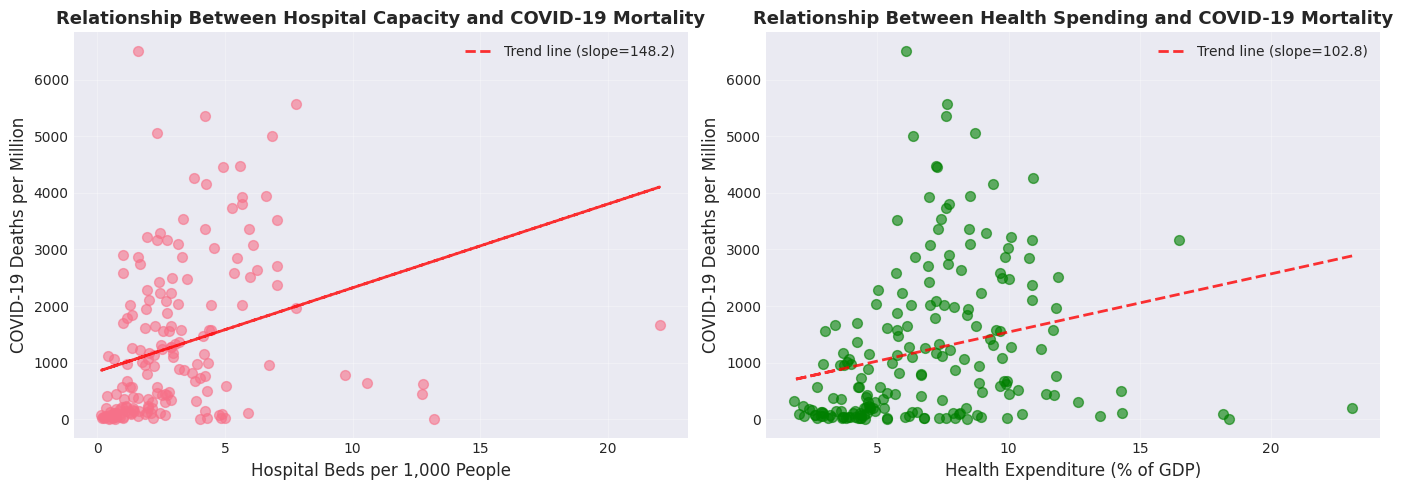

Figure 1: Scatter plots showing relationships between healthcare capacity indicators and COVID-19 mortality rates. This figure presents two scatter plots examining the relationship between healthcare capacity and COVID-19 outcomes. The left panel shows hospital beds per 1,000 people versus COVID-19 deaths per million, with a trend line indicating the relationship. The right panel displays health expenditure as a percentage of GDP versus COVID-19 deaths per million. Both plots include axis labels ("Hospital Beds per 1,000 People" and "Health Expenditure (%% of GDP)" on the x-axes, "COVID-19 Deaths per Million" on the y-axes) and trend lines to visualize the direction and strength of relationships.


In [13]:
# Visualisation 1: Scatter plot - Hospital Beds vs COVID-19 Deaths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Hospital beds vs COVID-19 deaths
if 'hospital_beds_per_1000' in final_df.columns and 'total_deaths_per_million' in final_df.columns:
    ax1 = axes[0]
    data_subset = final_df[['hospital_beds_per_1000', 'total_deaths_per_million', 'location']].dropna()
    
    ax1.scatter(data_subset['hospital_beds_per_1000'], 
               data_subset['total_deaths_per_million'],
               alpha=0.6, s=50)
    ax1.set_xlabel('Hospital Beds per 1,000 People', fontsize=12)
    ax1.set_ylabel('COVID-19 Deaths per Million', fontsize=12)
    ax1.set_title('Relationship Between Hospital Capacity and COVID-19 Mortality', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    if len(data_subset) > 1:
        z = np.polyfit(data_subset['hospital_beds_per_1000'], 
                      data_subset['total_deaths_per_million'], 1)
        p = np.poly1d(z)
        ax1.plot(data_subset['hospital_beds_per_1000'], 
                p(data_subset['hospital_beds_per_1000']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend line (slope={z[0]:.1f})')
        ax1.legend()

# Plot 2: Health expenditure vs COVID-19 deaths
if 'health_expenditure_pct_gdp' in final_df.columns and 'total_deaths_per_million' in final_df.columns:
    ax2 = axes[1]
    data_subset2 = final_df[['health_expenditure_pct_gdp', 'total_deaths_per_million', 'location']].dropna()
    
    ax2.scatter(data_subset2['health_expenditure_pct_gdp'], 
               data_subset2['total_deaths_per_million'],
               alpha=0.6, s=50, color='green')
    ax2.set_xlabel('Health Expenditure (% of GDP)', fontsize=12)
    ax2.set_ylabel('COVID-19 Deaths per Million', fontsize=12)
    ax2.set_title('Relationship Between Health Spending and COVID-19 Mortality', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add trend line
    if len(data_subset2) > 1:
        z2 = np.polyfit(data_subset2['health_expenditure_pct_gdp'], 
                       data_subset2['total_deaths_per_million'], 1)
        p2 = np.poly1d(z2)
        ax2.plot(data_subset2['health_expenditure_pct_gdp'], 
                p2(data_subset2['health_expenditure_pct_gdp']), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend line (slope={z2[0]:.1f})')
        ax2.legend()

plt.tight_layout()
plt.savefig('health_capacity_vs_covid_deaths.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Scatter plots showing relationships between healthcare capacity indicators and COVID-19 mortality rates. This figure presents two scatter plots examining the relationship between healthcare capacity and COVID-19 outcomes. The left panel shows hospital beds per 1,000 people versus COVID-19 deaths per million, with a trend line indicating the relationship. The right panel displays health expenditure as a percentage of GDP versus COVID-19 deaths per million. Both plots include axis labels (\"Hospital Beds per 1,000 People\" and \"Health Expenditure (%% of GDP)\" on the x-axes, \"COVID-19 Deaths per Million\" on the y-axes) and trend lines to visualize the direction and strength of relationships.")

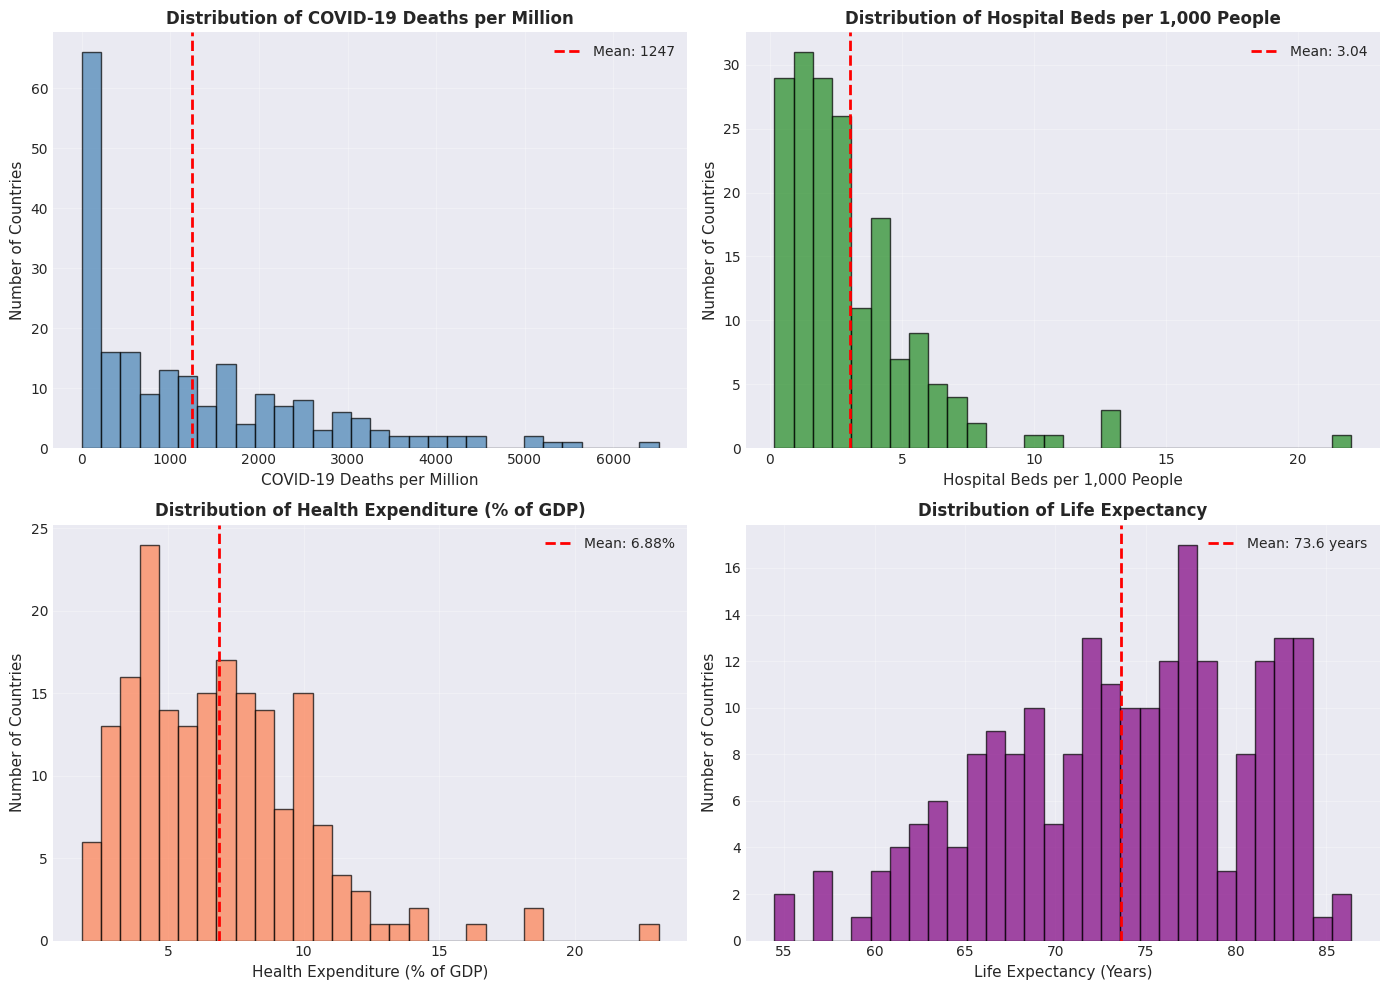

Figure 2: Histograms showing the distribution of key variables across countries. This figure presents four histograms displaying the distribution of key variables: COVID-19 deaths per million, hospital beds per 1,000 people, health expenditure (%% of GDP), and life expectancy. Each histogram includes axis labels, a mean indicator line, and shows the distribution shape across the 213 countries in the analysis. The x-axes are labeled with the variable names and units, while the y-axes show "Number of Countries."


In [14]:
# Visualisation 2: Distribution of key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot distributions
if 'total_deaths_per_million' in final_df.columns:
    ax = axes[0, 0]
    data = final_df['total_deaths_per_million'].dropna()
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_xlabel('COVID-19 Deaths per Million', fontsize=11)
    ax.set_ylabel('Number of Countries', fontsize=11)
    ax.set_title('Distribution of COVID-19 Deaths per Million', fontsize=12, fontweight='bold')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.0f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

if 'hospital_beds_per_1000' in final_df.columns:
    ax = axes[0, 1]
    data = final_df['hospital_beds_per_1000'].dropna()
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
    ax.set_xlabel('Hospital Beds per 1,000 People', fontsize=11)
    ax.set_ylabel('Number of Countries', fontsize=11)
    ax.set_title('Distribution of Hospital Beds per 1,000 People', fontsize=12, fontweight='bold')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

if 'health_expenditure_pct_gdp' in final_df.columns:
    ax = axes[1, 0]
    data = final_df['health_expenditure_pct_gdp'].dropna()
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='coral')
    ax.set_xlabel('Health Expenditure (% of GDP)', fontsize=11)
    ax.set_ylabel('Number of Countries', fontsize=11)
    ax.set_title('Distribution of Health Expenditure (% of GDP)', fontsize=12, fontweight='bold')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}%')
    ax.legend()
    ax.grid(True, alpha=0.3)

if 'life_expectancy_years' in final_df.columns:
    ax = axes[1, 1]
    data = final_df['life_expectancy_years'].dropna()
    ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='purple')
    ax.set_xlabel('Life Expectancy (Years)', fontsize=11)
    ax.set_ylabel('Number of Countries', fontsize=11)
    ax.set_title('Distribution of Life Expectancy', fontsize=12, fontweight='bold')
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f} years')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('variable_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Histograms showing the distribution of key variables across countries. This figure presents four histograms displaying the distribution of key variables: COVID-19 deaths per million, hospital beds per 1,000 people, health expenditure (%% of GDP), and life expectancy. Each histogram includes axis labels, a mean indicator line, and shows the distribution shape across the 213 countries in the analysis. The x-axes are labeled with the variable names and units, while the y-axes show \"Number of Countries.\"")


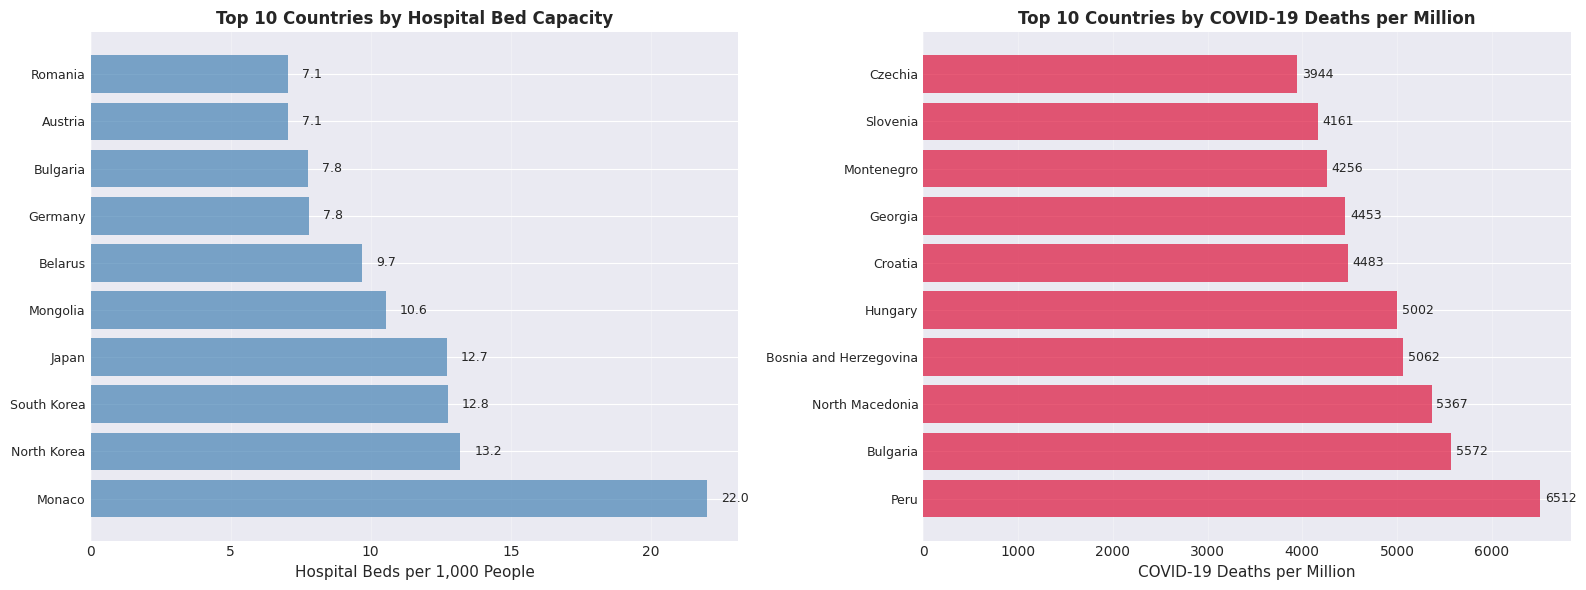

Figure 3: Bar charts comparing top countries by hospital bed capacity and COVID-19 mortality rates. This figure presents two horizontal bar charts. The left panel shows the top 10 countries by hospital bed capacity per 1,000 people, with axis labels "Hospital Beds per 1,000 People" on the x-axis and country names on the y-axis. The right panel displays the top 10 countries by COVID-19 deaths per million, with axis labels "COVID-19 Deaths per Million" on the x-axis and country names on the y-axis. Both charts include value labels on each bar.


In [15]:
# Visualisation 3: Top and bottom countries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 countries by hospital beds
if 'hospital_beds_per_1000' in final_df.columns:
    ax = axes[0]
    top_beds = final_df.nlargest(10, 'hospital_beds_per_1000')[['location', 'hospital_beds_per_1000', 'total_deaths_per_million']]
    top_beds = top_beds.dropna(subset=['hospital_beds_per_1000'])
    
    if len(top_beds) > 0:
        y_pos = np.arange(len(top_beds))
        bars = ax.barh(y_pos, top_beds['hospital_beds_per_1000'], color='steelblue', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_beds['location'], fontsize=9)
        ax.set_xlabel('Hospital Beds per 1,000 People', fontsize=11)
        ax.set_title('Top 10 Countries by Hospital Bed Capacity', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(top_beds.iterrows()):
            ax.text(row['hospital_beds_per_1000'] + 0.5, i, 
                   f"{row['hospital_beds_per_1000']:.1f}", 
                   va='center', fontsize=9)

# Countries with highest and lowest COVID-19 deaths
if 'total_deaths_per_million' in final_df.columns:
    ax = axes[1]
    top_deaths = final_df.nlargest(10, 'total_deaths_per_million')[['location', 'total_deaths_per_million']]
    top_deaths = top_deaths.dropna(subset=['total_deaths_per_million'])
    
    if len(top_deaths) > 0:
        y_pos = np.arange(len(top_deaths))
        bars = ax.barh(y_pos, top_deaths['total_deaths_per_million'], color='crimson', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_deaths['location'], fontsize=9)
        ax.set_xlabel('COVID-19 Deaths per Million', fontsize=11)
        ax.set_title('Top 10 Countries by COVID-19 Deaths per Million', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(top_deaths.iterrows()):
            ax.text(row['total_deaths_per_million'] + 50, i, 
                   f"{row['total_deaths_per_million']:.0f}", 
                   va='center', fontsize=9)

plt.tight_layout()
plt.savefig('top_countries_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: Bar charts comparing top countries by hospital bed capacity and COVID-19 mortality rates. This figure presents two horizontal bar charts. The left panel shows the top 10 countries by hospital bed capacity per 1,000 people, with axis labels \"Hospital Beds per 1,000 People\" on the x-axis and country names on the y-axis. The right panel displays the top 10 countries by COVID-19 deaths per million, with axis labels \"COVID-19 Deaths per Million\" on the x-axis and country names on the y-axis. Both charts include value labels on each bar.")


In [16]:
# Regression Analysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

print("="*60)
print("Regression Analysis")
print("="*60)

# Prepare data for regression
regression_df = final_df[['total_deaths_per_million', 'hospital_beds_per_1000', 
                          'health_expenditure_pct_gdp', 'life_expectancy_years']].dropna()

print(f"\nCountries included in regression analysis: {len(regression_df)}")

if len(regression_df) > 10:
    # Multiple regression: COVID-19 deaths as dependent variable
    X = regression_df[['hospital_beds_per_1000', 'health_expenditure_pct_gdp', 'life_expectancy_years']]
    y = regression_df['total_deaths_per_million']
    
    # Add constant for intercept
    X_with_const = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X_with_const).fit()
    
    print("\n" + "="*60)
    print("Multiple Linear Regression Results")
    print("="*60)
    print("Dependent Variable: COVID-19 Deaths per Million")
    print("\nModel Summary:")
    print(model.summary())
    
    print("\n" + "="*60)
    print("Key Findings:")
    print("="*60)
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.3f}")
    print(f"F-statistic: {model.fvalue:.2f}")
    print(f"P-value (F-statistic): {model.f_pvalue:.4f}")
    
    print("\nCoefficients:")
    for i, coef in enumerate(model.params.index):
        if coef != 'const':
            pvalue = model.pvalues[coef]
            sig = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else ""
            print(f"  {coef}: {model.params[coef]:.2f} (p={pvalue:.4f}){sig}")
else:
    print("Insufficient data for regression analysis (need at least 10 countries with complete data)")


Regression Analysis

Countries included in regression analysis: 176

Multiple Linear Regression Results
Dependent Variable: COVID-19 Deaths per Million

Model Summary:
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.274
Model:                                  OLS   Adj. R-squared:                  0.262
Method:                       Least Squares   F-statistic:                     21.66
Date:                      Sun, 23 Nov 2025   Prob (F-statistic):           6.01e-12
Time:                              23:14:58   Log-Likelihood:                -1493.7
No. Observations:                       176   AIC:                             2995.
Df Residuals:                           172   BIC:                             3008.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                        